In [1]:
import EddyDetectionV2 as eddy
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from tqdm import tqdm
import ast
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
from matplotlib.colors import LinearSegmentedColormap

In [2]:
time = ['2018-06-01T00:00:00.000000000','2018-06-30T00:00:00.000000000']
####################################################################


# Import data #######################################################################################################################
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(70,75)).sel(X=slice(-22,2))
depth_no_nan = depth
depth = depth.where(depth > 0, np.nan)

df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Background_var_eddies.nc')
df2 = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/OceanSpyStructureDimsAndVar.nc')
df3 = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Background_var.nc')
df['dxC'] = df2['dxC']
df['dxG'] = df2['dxG']
df['dyC'] = df2['dyC']
df['dyG'] = df2['dyG']
df['HFacC'] = df2['HFacC']
df['rA'] = df2['rA']
df['HFacW'] = df2['HFacW']
df['rAz'] = df2['rAz']
df['fCoriG'] = df2['fCoriG']
df['HFacS'] = df2['HFacS']
df['S'] = df3['S'].sel(Z=-1)
df['Temp'] = df3['Temp'].sel(Z=-1)

df_OW = df['Okubo_Weiss']
df_OW = df_OW*(1/(10**(-9)))
df_eta = df['Eta']
U = df['U']
V = df['V']
X = df['X']
Y = df['Y']

od = ospy.OceanDataset(df)
od = od.compute.horizontal_velocity_magnitude()
od = od.compute.eddy_kinetic_energy()
od = od.compute.missing_horizontal_spacing()
od = od.compute.normal_strain()
od = od.compute.shear_strain()
od = od.compute.vertical_relative_vorticity()
# od = od.compute.relative_vorticity()
# od = od.compute.Ertel_potential_vorticity()

df_hor_vel = od['hor_vel']
df_EKE = od['EKE']
df_nS = od['n_strain']
df_sS = od['s_strain']
df_rV = od['momVort3']
# Delete no longer used variables which uses memory
del od, df
#####################################################################################################################################
# Child domain
domain_center = [[-20,0],[71,74]]
OW_center = df_OW.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1])).sel(Z=-1)
eta_center = df_eta.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Parent domain
eta = df_eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1))
OW = df_OW.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1)).sel(Z=-1)


# Define time extent
eta = eta.sel(time=slice(time[0],time[1]))
eta_center = eta_center.sel(time=slice(time[0],time[1]))
OW = OW.sel(time=slice(time[0],time[1]))
OW_center = OW_center.sel(time=slice(time[0],time[1]))
hor_vel = df_hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

U = U.sel(Xp1=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))
V = V.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Yp1=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

X = X.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2))
Y = Y.sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2))

eta = eta.where(depth > 0, np.nan)
OW = OW.where(depth > 0, np.nan)


Computing magnitude of horizontal velocity
Computing weighted_mean.
Computing weighted_mean.
Computing kinetic energy using the following parameters: {'eps_nh': 0}.
Computing missing horizontal spacing.
Computing normal component of strain.
Computing divergence.
Computing shear component of strain.
Computing vertical component of relative vorticity.
Computing curl.


In [3]:
# Interpolating U to the target grid (X, Y)
U_interp = U.interp(Xp1=X, Y=Y, method='linear')

# Interpolating V to the target grid (X, Y)
V_interp = V.interp(X=X, Yp1=Y, method='linear')

# Drop the existing Y coordinate in V_interp to avoid conflicts
U_interp = U_interp.drop_vars('X')
V_interp = V_interp.drop_vars('Y')


# Rename the dimensions and coordinates
U_interp = U_interp.rename({'Xp1': 'X'})
V_interp = V_interp.rename({'Yp1': 'Y'})


# Ensure the coordinates are updated correctly
U_interp_r = U_interp.assign_coords(X=X, Y=Y)
V_interp_r = V_interp.assign_coords(X=X, Y=Y)

/tmp/ipykernel_3969098/1989897581.py:13: UserWarning: rename 'Xp1' to 'X' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  U_interp = U_interp.rename({'Xp1': 'X'})
/tmp/ipykernel_3969098/1989897581.py:14: UserWarning: rename 'Yp1' to 'Y' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  V_interp = V_interp.rename({'Yp1': 'Y'})


In [4]:
# Resample data
time = ['2018-06-01T00:00:00.000000000','2018-06-30T00:00:00.000000000']
eta = eta.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
OW = OW.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')
hor_vel = df_hor_vel.resample(time='D').mean(dim='time')

hor_vel = hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

FWC = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWC_full_domain.nc')['__xarray_dataarray_variable__'].sel(Y=slice(70,75)).sel(X=slice(-22,2)).sel(time=slice(time[0],time[1]))
FWC = FWC.resample(time='D').mean(dim='time')
EKE = df_EKE.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))
df_nS = df_nS.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))
df_sS = df_sS.sel(Xp1=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Yp1=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))
df_rV = df_rV.sel(Xp1=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Yp1=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

eta = eta.where(depth > 0, np.nan)
OW = OW.where(depth > 0, np.nan)

In [5]:
with open("eddyCenterpoints_fullYear.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)


# Dates to find
dates_to_find = time

# Convert dates to numpy datetime64
dates_to_find = np.array(dates_to_find, dtype='datetime64[ns]')

# Find the index positions
indices = [df_eta.time.where(df_eta.time == date, drop=True).time.values[0] for date in dates_to_find]

# Convert the datetime64 values to integer indices
index_positions = [np.where(df_eta.time.values == date)[0][0] for date in dates_to_find]

print(index_positions)

eddyLocation = eddyLocation[index_positions[0]:index_positions[1]+1]

[273, 302]


In [6]:
eddies = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Eddies_fullYear.nc')
eddies = eddies['EddyDetection'].sel(time=slice(time[0],time[1]))
EKE_std = EKE.std()
cond = (eddies == 0) & (EKE >= EKE_std)
eddies = eddies.where(~cond,other=4)

In [7]:
display(X)

<xarray.DataArray 'X' (X: 510)>
array([-21.981382, -21.926378, -21.871497, ...,   1.878965,   1.936218,
         1.993614])
Coordinates:
  * X        (X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.822 1.879 1.936 1.994
Attributes:
    long_name:  longitude of cell center
    units:      degrees_east

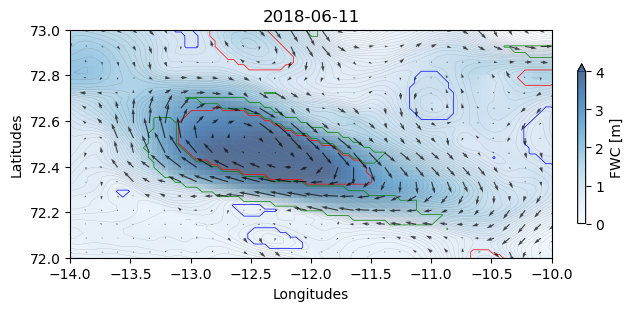

In [8]:
fig, ax = plt.subplots(figsize=(6.2217,3),layout='constrained')

eddies = eddies.where(eddies !=0,other=np.nan)
eddies = eddies.fillna(0)

# Define the custom colormap
colors = ['red', 'blue', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

time = 10
mesh = ax.pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='Blues',vmin=0,vmax=4,alpha=0.7,zorder=0)
cbar = fig.colorbar(mesh, pad=0.01, shrink=0.7, extend='max')
cbar.set_label('FWC [m]')
ax.contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==1,other=0),[0.5],colors='red',zorder=2,linewidths=0.5)
ax.contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==2,other=0),[1.5],colors='blue',zorder=2,linewidths=0.5)
ax.contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==4,other=0),[3.5],colors='green',zorder=2,linewidths=0.5)
ax.contour(eta.X,eta.Y,eta[time],levels=np.arange(eta.min(),eta.max(),0.003),colors='grey',linewidths=0.15,zorder=1)

subsample_factor = 3

q_X, q_Y = np.meshgrid(hor_vel.X,hor_vel.Y) 
quiver = ax.quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
        U_interp.values[time][::subsample_factor, ::subsample_factor],
        V_interp.values[time][::subsample_factor, ::subsample_factor],
        color='black', scale=5, scale_units='xy', alpha=0.7, zorder=2)

ax.set_xlim(-14,-10)
ax.set_ylim(72,73)

ax.set_title(str(eddies[time].time.values)[0:10])
ax.set_xlabel('Longitudes')
ax.set_ylabel('Latitudes')

fig.savefig(r'/nird/home/ekv036/MSc/Fig/EddyEKEOuterAreaEX',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

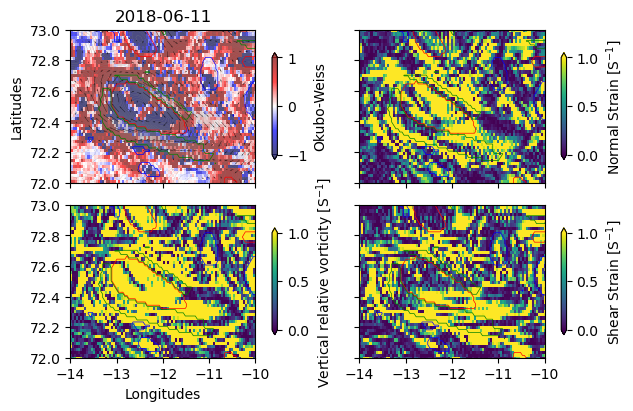

In [22]:
import matplotlib.ticker as ticker
fig, ax = plt.subplot_mosaic([[0,1],[2,3]], sharey=True,sharex=True,
    figsize=(6.2217,4),layout='constrained')

eddies = eddies.where(eddies !=0,other=np.nan)
eddies = eddies.fillna(0)

# Define the custom colormap
colors = ['red', 'blue', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

time = 10
mesh = ax[0].pcolormesh(OW.X,OW.Y,OW[time],cmap='seismic',vmin=-1,vmax=1,alpha=0.7,zorder=0)
cbar = fig.colorbar(mesh, pad=0.01, shrink=0.7, extend='both')
cbar.set_label('Okubo-Weiss')


ax[0].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==1,other=0),[0.5],colors='red',zorder=2,linewidths=0.5)
ax[0].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==2,other=0),[1.5],colors='blue',zorder=2,linewidths=0.5)
ax[0].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==4,other=0),[3.5],colors='green',zorder=2,linewidths=0.5)
ax[0].contour(eta.X,eta.Y,eta[time],levels=np.arange(eta.min(),eta.max(),0.003),colors='grey',linewidths=0.15,zorder=1)

subsample_factor = 3

q_X, q_Y = np.meshgrid(hor_vel.X,hor_vel.Y) 
quiver = ax[0].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
        U_interp.values[time][::subsample_factor, ::subsample_factor],
        V_interp.values[time][::subsample_factor, ::subsample_factor],
        color='black', scale=5, scale_units='xy', alpha=0.7, zorder=1)

ax[0].set_xlim(-14,-10)
ax[0].set_ylim(72,73)

ax[0].set_title(str(eddies[time].time.values)[0:10])
ax[2].set_xlabel('Longitudes')
ax[0].set_ylabel('Latitudes')


ax[1].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==1,other=0),[0.5],colors='red',zorder=2,linewidths=0.5)
ax[1].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==2,other=0),[1.5],colors='blue',zorder=2,linewidths=0.5)
ax[1].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==4,other=0),[3.5],colors='green',zorder=2,linewidths=0.5)
ax[1].contour(eta.X,eta.Y,eta[time],levels=np.arange(eta.min(),eta.max(),0.003),colors='grey',linewidths=0.15,zorder=1)

mesh = ax[1].pcolormesh(df_nS.X,df_nS.Y,df_nS[time]**2*(1/(10**(-9))),vmin=0,vmax=1)
cbar = fig.colorbar(mesh, pad=0.01, shrink=0.7,extend='both')
cbar.set_label('Normal Strain [S$^{-1}$]')



ax[3].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==1,other=0),[0.5],colors='red',zorder=2,linewidths=0.5)
ax[3].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==2,other=0),[1.5],colors='blue',zorder=2,linewidths=0.5)
ax[3].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==4,other=0),[3.5],colors='green',zorder=2,linewidths=0.5)
ax[3].contour(eta.X,eta.Y,eta[time],levels=np.arange(eta.min(),eta.max(),0.003),colors='grey',linewidths=0.15,zorder=1)

mesh = ax[3].pcolormesh(df_sS.Xp1,df_sS.Yp1,df_sS[time]**2*(1/(10**(-9))),vmin=0,vmax=1)
cbar = fig.colorbar(mesh, pad=0.01, shrink=0.7,extend='both')
cbar.set_label('Shear Strain [S$^{-1}$]')


ax[2].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==1,other=0),[0.5],colors='red',zorder=2,linewidths=0.5)
ax[2].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==2,other=0),[1.5],colors='blue',zorder=2,linewidths=0.5)
ax[2].contour(eddies.X,eddies.Y,eddies[time].where(eddies[time]==4,other=0),[3.5],colors='green',zorder=2,linewidths=0.5)
ax[2].contour(eta.X,eta.Y,eta[time],levels=np.arange(eta.min(),eta.max(),0.003),colors='grey',linewidths=0.15,zorder=1)

mesh = ax[2].pcolormesh(df_rV.Xp1,df_rV.Yp1,df_rV[time]**2*(1/(10**(-9))),vmin=0,vmax=1)
cbar = fig.colorbar(mesh, pad=0.01, shrink=0.7,extend='both')
cbar.set_label('Vertical relative vorticity [S$^{-1}$]')


fig.savefig(r'/nird/home/ekv036/MSc/Fig/EddyOWEX',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

In [10]:
df_rV[time]

<xarray.DataArray 'momVort3' (Yp1: 321, Xp1: 509)>
array([[-4.08383911e-05, -7.50615558e-05, -5.71130592e-05, ...,
         6.20257274e-06,  1.92931013e-06,  7.15734401e-06],
       [ 4.72407361e-05,  1.38731988e-05,  1.30082217e-05, ...,
         2.78438410e-06,  9.04230702e-06,  4.40525669e-06],
       [ 3.19626387e-05,  8.14044832e-06,  3.19415346e-05, ...,
         2.91655665e-06,  6.75457928e-06,  8.51598389e-06],
       ...,
       [            nan,             nan,             nan, ...,
        -1.91281791e-05, -2.28327669e-05, -2.89754274e-05],
       [            nan,             nan,             nan, ...,
        -1.25875914e-05, -1.23556025e-06,  6.22739820e-06],
       [            nan,             nan,             nan, ...,
         1.15146819e-05, -1.99816470e-06, -1.65707365e-05]])
Coordinates:
    Z        float64 -1.0
  * Xp1      (Xp1) float64 -21.96 -21.9 -21.85 -21.79 ... 1.849 1.909 1.964
  * Yp1      (Yp1) float64 69.01 69.03 69.04 69.06 ... 75.85 75.89 75.93 75.97
    time     datetime64[ns] 2018-06-11
    XG       (Yp1, Xp1) float64 ...
    YG       (Yp1, Xp1) float64 ...
Attributes:
    units:      s^-1
    long_name:  vertical component of relative vorticity

# Comparing all tried methods

In [11]:
eddies_zero = xr.zeros_like(eta[0]).rename('Eddies')
eddies_vel_from_int = eddy.Full_eddy_region_v1(eddyCenterpoints=eddyLocation[time][0],eta=eta[time],hor_vel=hor_vel[time],warm=True,eddiesData=eddies_zero,min_vel_diff=0.1,percentage_diff_vel=70)
eddies_vel_from_int = eddy.Full_eddy_region_v1(eddyCenterpoints=eddyLocation[time][1],eta=eta[time],hor_vel=hor_vel[time],cold=True,eddiesData=eddies_vel_from_int,min_vel_diff=0.1,percentage_diff_vel=70)
eddies_EKE = eddies[time]
eddies_zero = xr.zeros_like(eta[0]).rename('Eddies')
eddies_SSH_outermost_enclosed = eddy.Full_eddy_region_v2(eddyCenterpoints=eddyLocation[time][0],eta=eta[time],warm=True,eddiesData=eddies_zero)
eddies_SSH_outermost_enclosed = eddy.Full_eddy_region_v2(eddyCenterpoints=eddyLocation[time][1],eta=eta[time],cold=True,eddiesData=eddies_SSH_outermost_enclosed)

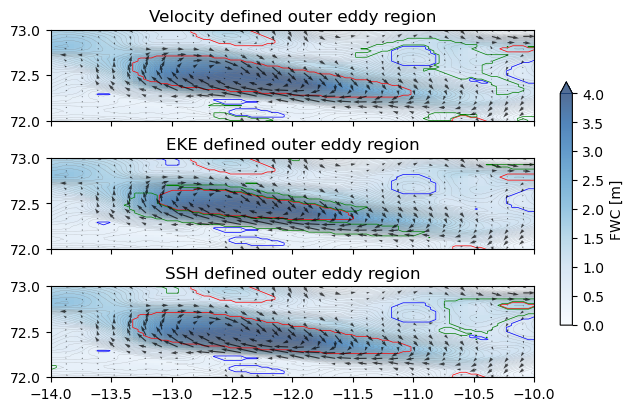

In [12]:
fig, ax = plt.subplot_mosaic([[0],[1],[2]],sharex=True,sharey=True,
                             figsize=(6.2217,4),layout='constrained')


mesh = ax[0].pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='Blues',vmin=0,vmax=4,alpha=0.7,zorder=0)
cbar = fig.colorbar(mesh,ax=[ax[0],ax[1],ax[2]], pad=0.01, shrink=0.7, extend='max')
cbar.set_label('FWC [m]')
ax[0].contour(eddies_vel_from_int.X,eddies_vel_from_int.Y,eddies_vel_from_int.where(eddies_vel_from_int==1,other=0),[0.5],colors='red',zorder=2,linewidths=0.5)
ax[0].contour(eddies.X,eddies.Y,eddies_vel_from_int.where(eddies_vel_from_int==2,other=0),[1.5],colors='blue',zorder=2,linewidths=0.5)
ax[0].contour(eddies.X,eddies.Y,eddies_vel_from_int.where(eddies_vel_from_int==4,other=0),[3.5],colors='green',zorder=2,linewidths=0.5)
ax[0].contour(eta.X,eta.Y,eta[time],levels=np.arange(eta.min(),eta.max(),0.003),colors='grey',linewidths=0.15,zorder=1)

subsample_factor = 3

q_X, q_Y = np.meshgrid(hor_vel.X,hor_vel.Y) 
quiver = ax[0].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
        U_interp.values[time][::subsample_factor, ::subsample_factor],
        V_interp.values[time][::subsample_factor, ::subsample_factor],
        color='black', scale=5, scale_units='xy', alpha=0.7, zorder=2)

ax[0].set_xlim(-14,-10)
ax[0].set_ylim(72,73)
ax[0].set_title('Velocity defined outer eddy region')

ax[1].pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='Blues',vmin=0,vmax=4,alpha=0.7,zorder=0)
ax[1].contour(eddies.X,eddies.Y,eddies_EKE.where(eddies_EKE==1,other=0),[0.5],colors='red',zorder=2,linewidths=0.5)
ax[1].contour(eddies.X,eddies.Y,eddies_EKE.where(eddies_EKE==2,other=0),[1.5],colors='blue',zorder=2,linewidths=0.5)
ax[1].contour(eddies.X,eddies.Y,eddies_EKE.where(eddies_EKE==4,other=0),[3.5],colors='green',zorder=2,linewidths=0.5)
ax[1].contour(eta.X,eta.Y,eta[time],levels=np.arange(eta.min(),eta.max(),0.003),colors='grey',linewidths=0.15,zorder=1)

subsample_factor = 3

q_X, q_Y = np.meshgrid(hor_vel.X,hor_vel.Y) 
quiver = ax[1].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
        U_interp.values[time][::subsample_factor, ::subsample_factor],
        V_interp.values[time][::subsample_factor, ::subsample_factor],
        color='black', scale=5, scale_units='xy', alpha=0.7, zorder=2)

ax[1].set_title('EKE defined outer eddy region')

ax[2].pcolormesh(FWC.X,FWC.Y,FWC[time],cmap='Blues',vmin=0,vmax=4,alpha=0.7,zorder=0)
ax[2].contour(eddies.X,eddies.Y,eddies_SSH_outermost_enclosed.where(eddies_SSH_outermost_enclosed==1,other=0),[0.5],colors='red',zorder=2,linewidths=0.5)
ax[2].contour(eddies.X,eddies.Y,eddies_SSH_outermost_enclosed.where(eddies_SSH_outermost_enclosed==2,other=0),[1.5],colors='blue',zorder=2,linewidths=0.5)
ax[2].contour(eddies.X,eddies.Y,eddies_SSH_outermost_enclosed.where(eddies_SSH_outermost_enclosed==4,other=0),[3.5],colors='green',zorder=2,linewidths=0.5)
ax[2].contour(eta.X,eta.Y,eta[time],levels=np.arange(eta.min(),eta.max(),0.003),colors='grey',linewidths=0.15,zorder=1)

subsample_factor = 3

q_X, q_Y = np.meshgrid(hor_vel.X,hor_vel.Y) 
quiver = ax[2].quiver(q_X[::subsample_factor, ::subsample_factor], q_Y[::subsample_factor, ::subsample_factor],
        U_interp.values[time][::subsample_factor, ::subsample_factor],
        V_interp.values[time][::subsample_factor, ::subsample_factor],
        color='black', scale=5, scale_units='xy', alpha=0.7, zorder=2)

ax[2].set_title('SSH defined outer eddy region')

fig.savefig(r'/nird/home/ekv036/MSc/Fig/EddyOuterRegionMethodsEX',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)